In [1]:
# Microbiome Specific Integrated Tool
# This Sample Size Estimation is Solely Based on the Microbiome Specific Power Calcualtion Described in this Paper:
# https://www.sciencedirect.com/science/article/pii/S1933021922017366?via%3Dihub
# Concepts like Type1: Comparison of two means in normally distributed continuous data
# Concepts like Type2: Comparison of the difference in proportions between two groups
# Concepts like Type3: Comparison of the odds between two groups

# Following this publication for Power Calculation
# https://www.nature.com/articles/s41385-022-00548-1

# By: Ashok K. Sharma
# Date: 09-23-2024

Available columns in the dataset:
Sample
Observed
Shannon
BarcodeSeq
LinkerPrimer
ReversePrimer
Sample_received
Sample_Type
Group
Alcohol
HPB_pmol
HPB_pmol_mg_DNA
Description


Enter the column name you want to use for power calculation:  Shannon



Mean in Cases: 2.50
Mean in Controls: 2.77


Enter the threshold value for Shannon diversity:  2.6


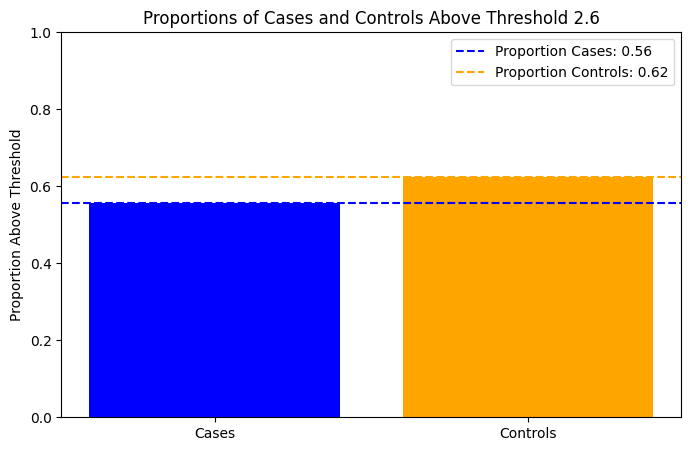


Select the type of analysis you want to perform:
1: Compare means (Selected Column)
2: Compare proportions (Above Threshold)
3: Odds ratio analysis (Above Threshold)


Enter the number corresponding to your choice (1/2/3):  1


Power: 0.50, Sample Size: 61
Power: 0.55, Sample Size: 69
Power: 0.60, Sample Size: 78
Power: 0.65, Sample Size: 87
Power: 0.70, Sample Size: 98
Power: 0.75, Sample Size: 110
Power: 0.80, Sample Size: 124


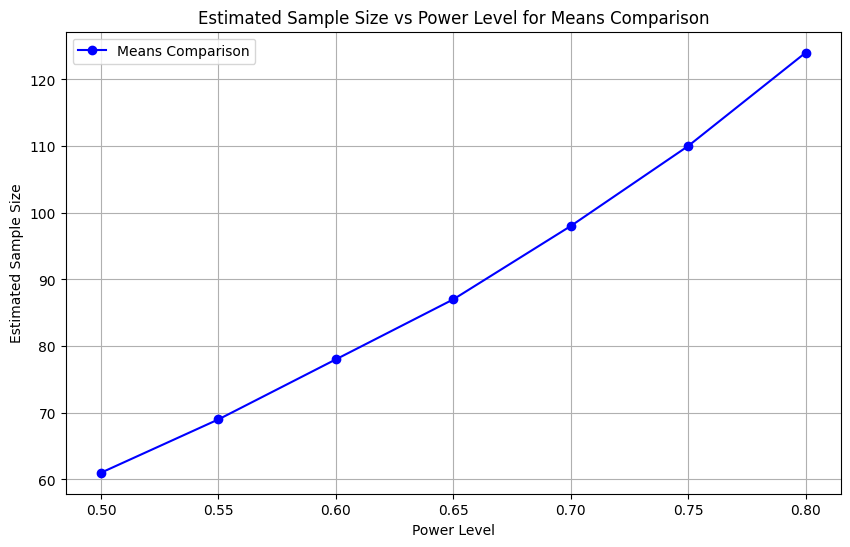

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load the microbiome diversity data from CSV
data = pd.read_csv('../data/Richness_total.csv')  # Update with your actual filename

# Display all column names for user to select
print("Available columns in the dataset:")
for col in data.columns:
    print(col)

# Ask user to enter the column to use for power calculation
column_choice = input("Enter the column name you want to use for power calculation: ")

# Check if the column exists in the DataFrame
if column_choice not in data.columns:
    raise ValueError(f"Column '{column_choice}' does not exist in the dataset.")

# Split data into Cases and Controls
case_data = data[data['Group'] == 'Cases'][column_choice]
control_data = data[data['Group'] == 'Controls'][column_choice]

# Calculate means in both groups
P_case = np.mean(case_data)
P_control = np.mean(control_data)

print(f"\nMean in Cases: {P_case:.2f}")
print(f"Mean in Controls: {P_control:.2f}")

####################################### Just to check the proportions based on Threshold ###################
# Ask for threshold value for calculating proportions
shannon_threshold = float(input("Enter the threshold value for Shannon diversity: "))

# Split data into Cases and Controls
case_data = data[data['Group'] == 'Cases'][column_choice]
control_data = data[data['Group'] == 'Controls'][column_choice]

# Function to plot the proportions of cases and controls above the threshold
def plot_proportions(case_data, control_data, threshold):
    # Calculate proportions
    P1 = np.mean(case_data > threshold)  # Proportion in 'Cases'
    P2 = np.mean(control_data > threshold)  # Proportion in 'Controls'

    # Plot
    categories = ['Cases', 'Controls']
    proportions = [P1, P2]

    plt.figure(figsize=(8, 5))
    plt.bar(categories, proportions, color=['blue', 'orange'])
    plt.ylabel('Proportion Above Threshold')
    plt.title(f'Proportions of Cases and Controls Above Threshold {threshold}')
    plt.ylim(0, 1)
    plt.axhline(y=P1, color='blue', linestyle='--', label=f'Proportion Cases: {P1:.2f}')
    plt.axhline(y=P2, color='orange', linestyle='--', label=f'Proportion Controls: {P2:.2f}')
    plt.legend()
    plt.show()

# Plot the proportions
plot_proportions(case_data, control_data, shannon_threshold)
######################################################

# Function to calculate effect size
def calculate_effect_size(case_data, control_data):
    mean_diff = np.mean(case_data) - np.mean(control_data)
    pooled_std_dev = np.sqrt((np.var(case_data) + np.var(control_data)) / 2)
    return mean_diff / pooled_std_dev if pooled_std_dev != 0 else np.nan

# Function to calculate sample size for equal groups
def sample_size_equal_groups(effect_size, std_dev, alpha=0.05, power=0.8):
    Z_alpha = norm.ppf(1 - alpha / 2)
    Z_beta = norm.ppf(power)
    numerator = 2 * (Z_alpha + Z_beta) ** 2 * std_dev ** 2
    denominator = effect_size ** 2
    return int(np.ceil(numerator / denominator)) if denominator > 0 else np.nan

# Function to calculate sample size for equal proportions
def sample_size_equal_proportions(P1, P2, alpha=0.05, power=0.8):
    Z_alpha = norm.ppf(1 - alpha / 2)
    Z_beta = norm.ppf(power)
    numerator = 2 * (Z_alpha + Z_beta) ** 2 * (P1 * (1 - P1) + P2 * (1 - P2))
    denominator = (P1 - P2) ** 2
    return int(np.ceil(numerator / denominator)) if denominator > 0 else np.nan

# Function to calculate odds ratio
def calculate_odds_ratio(P1, P2):
    odds1 = P1 / (1 - P1) if P1 < 1 else np.inf
    odds2 = P2 / (1 - P2) if P2 < 1 else np.inf
    return odds1 / odds2 if odds2 > 0 else np.nan

# Function to calculate sample size for odds ratio
def sample_size_odds_ratio(P1, P2, alpha=0.05, power=0.8):
    OR = calculate_odds_ratio(P1, P2)
    Z_alpha = norm.ppf(1 - alpha / 2)
    Z_beta = norm.ppf(power)
    numerator = (Z_alpha + Z_beta) ** 2
    denominator = np.log(OR) ** 2 * (1 / (P1 * (1 - P1)) + 1 / (P2 * (1 - P2)))
    return int(np.ceil(numerator / denominator)) if denominator > 0 else np.nan

# User input for type of analysis
print("\nSelect the type of analysis you want to perform:")
print("1: Compare means (Selected Column)")
print("2: Compare proportions (Above Threshold)")
print("3: Odds ratio analysis (Above Threshold)")
analysis_type = int(input("Enter the number corresponding to your choice (1/2/3): "))

# Define power levels
power_levels = np.arange(0.50, 0.85, 0.05)  # From 0.50 to 0.80
sample_sizes = []

if analysis_type == 1:  # Compare Means
    # Calculate effect size and standard deviation
    effect_size = calculate_effect_size(case_data, control_data)
    std_dev = np.sqrt((np.var(case_data) + np.var(control_data)) / 2)

    # Calculate sample size for each power level
    for power in power_levels:
        sample_size = sample_size_equal_groups(effect_size, std_dev, power=power)
        sample_sizes.append(sample_size)
        print(f"Power: {power:.2f}, Sample Size: {sample_size}")

    # Plot estimated sample sizes vs power levels
    plt.figure(figsize=(10, 6))
    plt.plot(power_levels, sample_sizes, marker='o', linestyle='-', color='blue', label='Means Comparison')
    plt.title('Estimated Sample Size vs Power Level for Means Comparison')
    plt.xlabel('Power Level')
    plt.ylabel('Estimated Sample Size')
    plt.xticks(power_levels)
    plt.grid()

elif analysis_type == 2:  # Compare Proportions
    # Ask for threshold value for calculating proportions
    #shannon_threshold = float(input("Enter the threshold value for Shannon diversity: "))

    # Calculate proportions above threshold
    P1 = np.mean(case_data > shannon_threshold)
    P2 = np.mean(control_data > shannon_threshold)

    print(f"Proportion of Cases above threshold: {P1:.2f}")
    print(f"Proportion of Controls above threshold: {P2:.2f}")

    # Calculate sample size for each power level
    for power in power_levels:
        sample_size = sample_size_equal_proportions(P1, P2, power=power)
        sample_sizes.append(sample_size)
        print(f"Power: {power:.2f}, Sample Size: {sample_size}")

    # Plot estimated sample sizes vs power levels
    plt.plot(power_levels, sample_sizes, marker='o', linestyle='-', color='green', label='Proportions Comparison')
    plt.title('Estimated Sample Size vs Power Level for Proportions Comparison')
    plt.xlabel('Power Level')
    plt.ylabel('Estimated Sample Size')
    plt.xticks(power_levels)
    plt.grid()

elif analysis_type == 3:  # Odds Ratio Analysis
    # Ask for threshold value for calculating proportions
    #shannon_threshold = float(input("Enter the threshold value for Shannon diversity: "))

    # Calculate proportions above threshold
    P1 = np.mean(case_data > shannon_threshold)
    P2 = np.mean(control_data > shannon_threshold)

    print(f"Proportion of Cases above threshold: {P1:.2f}")
    print(f"Proportion of Controls above threshold: {P2:.2f}")

    # Calculate sample size for each power level
    for power in power_levels:
        sample_size = sample_size_odds_ratio(P1, P2, power=power)
        sample_sizes.append(sample_size)
        print(f"Power: {power:.2f}, Sample Size: {sample_size}")

    # Plot estimated sample sizes vs power levels
    plt.plot(power_levels, sample_sizes, marker='o', linestyle='-', color='orange', label='Odds Ratio Analysis')
    plt.title('Estimated Sample Size vs Power Level for Odds Ratio Analysis')
    plt.xlabel('Power Level')
    plt.ylabel('Estimated Sample Size')
    plt.xticks(power_levels)
    plt.grid()

else:
    print("Invalid selection. Please run the script again.")

# Finalize the plot
plt.legend()
plt.show()

Available columns in the dataset:
Sample
Observed
Shannon
BarcodeSeq
LinkerPrimer
ReversePrimer
Sample_received
Sample_Type
Group
Alcohol
HPB_pmol
HPB_pmol_mg_DNA
Description


Enter the column name you want to use for power calculation:  Shannon



Mean in Cases: 2.44
Mean in Controls: 2.77


Enter the threshold value for Shannon diversity:  2.6


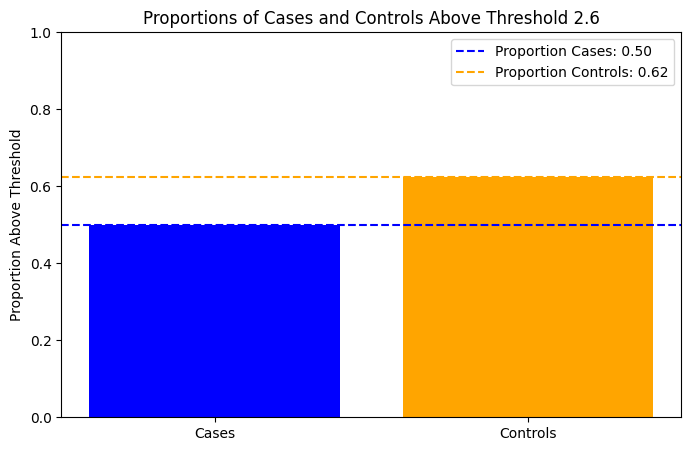


Select the type of analysis you want to perform:
1: Compare means (Selected Column)
2: Compare proportions (Above Threshold)
3: Odds ratio analysis (Above Threshold)


Enter the number corresponding to your choice (1/2/3):  2


Want to change Threshold for Type2 analysis?.


Enter the threshold value for Shannon diversity:  2.6


Proportion of Cases above threshold: 0.50
Proportion of Controls above threshold: 0.62
Equal group sizes detected. Using Equation C.
Power: 0.50, Sample Size: 239
Equal group sizes detected. Using Equation C.
Power: 0.55, Sample Size: 270
Equal group sizes detected. Using Equation C.
Power: 0.60, Sample Size: 304
Equal group sizes detected. Using Equation C.
Power: 0.65, Sample Size: 342
Equal group sizes detected. Using Equation C.
Power: 0.70, Sample Size: 383
Equal group sizes detected. Using Equation C.
Power: 0.75, Sample Size: 431
Equal group sizes detected. Using Equation C.
Power: 0.80, Sample Size: 487


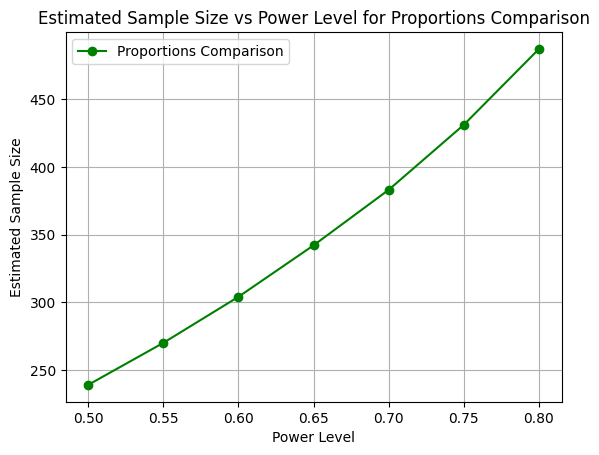

In [4]:
# What is Sample sizes are not equal

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load the microbiome diversity data from CSV
data = pd.read_csv('../data/Richness_total_Equal.csv')  # Update with your actual filename

# Display all column names for user to select
print("Available columns in the dataset:")
for col in data.columns:
    print(col)

# Ask user to enter the column to use for power calculation
column_choice = input("Enter the column name you want to use for power calculation: ")

# Check if the column exists in the DataFrame
if column_choice not in data.columns:
    raise ValueError(f"Column '{column_choice}' does not exist in the dataset.")

# Split data into Cases and Controls
case_data = data[data['Group'] == 'Cases'][column_choice]
control_data = data[data['Group'] == 'Controls'][column_choice]

# Calculate means in both groups
P_case = np.mean(case_data)
P_control = np.mean(control_data)

print(f"\nMean in Cases: {P_case:.2f}")
print(f"Mean in Controls: {P_control:.2f}")

####################################### Just to check the proportions based on Threshold ###################
# Ask for threshold value for calculating proportions
shannon_threshold = float(input("Enter the threshold value for Shannon diversity: "))

# Split data into Cases and Controls
case_data = data[data['Group'] == 'Cases'][column_choice]
control_data = data[data['Group'] == 'Controls'][column_choice]

# Function to plot the proportions of cases and controls above the threshold
def plot_proportions(case_data, control_data, threshold):
    # Calculate proportions
    P1 = np.mean(case_data > threshold)  # Proportion in 'Cases'
    P2 = np.mean(control_data > threshold)  # Proportion in 'Controls'

    # Plot
    categories = ['Cases', 'Controls']
    proportions = [P1, P2]

    plt.figure(figsize=(8, 5))
    plt.bar(categories, proportions, color=['blue', 'orange'])
    plt.ylabel('Proportion Above Threshold')
    plt.title(f'Proportions of Cases and Controls Above Threshold {threshold}')
    plt.ylim(0, 1)
    plt.axhline(y=P1, color='blue', linestyle='--', label=f'Proportion Cases: {P1:.2f}')
    plt.axhline(y=P2, color='orange', linestyle='--', label=f'Proportion Controls: {P2:.2f}')
    plt.legend()
    plt.show()

# Plot the proportions
plot_proportions(case_data, control_data, shannon_threshold)
######################################################

# Function to calculate effect size
def calculate_effect_size(case_data, control_data):
    mean_diff = np.mean(case_data) - np.mean(control_data)
    pooled_std_dev = np.sqrt((np.var(case_data) + np.var(control_data)) / 2)
    return mean_diff / pooled_std_dev if pooled_std_dev != 0 else np.nan

# Function to calculate sample size for equal groups
def sample_size_equal_groups(effect_size, std_dev, alpha=0.05, power=0.8):
    if effect_size == 0 or np.isnan(effect_size):
        return np.nan  # Avoid division by zero if effect size is invalid
    Z_alpha = norm.ppf(1 - alpha / 2)
    Z_beta = norm.ppf(power)
    numerator = 2 * (Z_alpha + Z_beta) ** 2 * std_dev ** 2
    denominator = effect_size ** 2
    return int(np.ceil(numerator / denominator)) if denominator > 0 else np.nan

# Function to calculate sample size based on Equation B (unequal group sizes)
def sample_size_unequal_groups(effect_size, std_dev, ratio, alpha=0.05, power=0.8):
    if effect_size == 0 or np.isnan(effect_size):
        return np.nan  # Avoid division by zero if effect size is invalid 
    Z_alpha = norm.ppf(1 - alpha / 2)  # Two-sided test
    Z_beta = norm.ppf(power)
    # Check if Z_beta is too large, which might cause overflow
    if np.isnan(Z_beta) or Z_beta == np.inf:
        print("Z_beta is too large or resulted in NaN, skipping this power level.")
        return np.nan
    numerator = (ratio + 1) * (Z_alpha + Z_beta) ** 2 * std_dev ** 2
    denominator = ratio * effect_size ** 2
    # Check if denominator is valid
    if denominator == 0 or np.isnan(denominator):
        print("Denominator is invalid (division by zero or NaN). Check the input values.")
        return np.nan  # Return NaN if denominator is invalid
    
    n2 = int(np.ceil(numerator / denominator))  # Sample size of the smaller group
    n1 = int(ratio * n2)  # Sample size of the larger group
    return n1, n2

# Function to calculate sample size for equal proportions
def sample_size_equal_proportions(P1, P2, alpha=0.05, power=0.8):
    Z_alpha = norm.ppf(1 - alpha / 2)
    Z_beta = norm.ppf(power)
    numerator = 2 * (Z_alpha + Z_beta) ** 2 * (P1 * (1 - P1) + P2 * (1 - P2))
    denominator = (P1 - P2) ** 2
    return int(np.ceil(numerator / denominator)) if denominator > 0 else np.nan

# Function to calculate sample size for unequal group sizes (Equation D)
def sample_size_unequal_proportions(P1, P2, ratio, alpha=0.05, power=0.8):
    Z_alpha = norm.ppf(1 - alpha / 2)  # Two-sided test
    Z_beta = norm.ppf(power)
    numerator = (Z_alpha + Z_beta) ** 2 * (P1 * (1 - P1) + P2 * (1 - P2))
    denominator = (P1 - P2) ** 2
    
    if denominator == 0 or np.isnan(denominator):
        return np.nan  # Avoid division by zero
    
    n2 = int(np.ceil(numerator / denominator))  # Sample size of smaller group
    n1 = int(np.ceil(ratio * n2))  # Sample size of larger group
    return n1, n2

# Function to calculate odds ratio
def calculate_odds_ratio(P1, P2):
    odds1 = P1 / (1 - P1) if P1 < 1 else np.inf
    odds2 = P2 / (1 - P2) if P2 < 1 else np.inf
    return odds1 / odds2 if odds2 > 0 else np.nan
    odds_ratio = odds1 / odds2
    return odds_ratio
    
# Function to calculate sample size for odds ratio
def sample_size_odds_ratio(P1, P2, alpha=0.05, power=0.8):
    OR = calculate_odds_ratio(P1, P2)
    Z_alpha = norm.ppf(1 - alpha / 2)
    Z_beta = norm.ppf(power)
    numerator = (Z_alpha + Z_beta) ** 2
    denominator = np.log(OR) ** 2 * (1 / (P1 * (1 - P1)) + 1 / (P2 * (1 - P2)))
    return int(np.ceil(numerator / denominator)) if denominator > 0 else np.nan

# Function to calculate sample size for unequal group sizes
def sample_size_unequal_odds_ratio(P1, P2, ratio, alpha=0.05, power=0.8):
    OR = calculate_odds_ratio(P1, P2)
    if OR == np.inf:
        print("One of the proportions is zero; odds ratio is infinite.")
        return np.nan  # Cannot calculate sample size
    Z_alpha = norm.ppf(1 - alpha / 2)  # Two-sided test
    Z_beta = norm.ppf(power)
    # Numerator based on Equation F (for odds ratio)
    numerator = (Z_alpha + Z_beta) ** 2
    # Denominator (effect size term involving proportions)
    denominator = np.log(OR) ** 2 * (1 / (P1 * (1 - P1)) + 1 / (P2 * (1 - P2)))
    # Sample size for smaller group
    if denominator <= 0:
        print("Denominator is zero or negative; invalid sample size.")
        return np.nan
    n2 = numerator / denominator
    n2 = int(np.ceil(n2))
    # Larger group sample size
    n1 = int(np.ceil(ratio * n2))
    return n1, n2

# User input for type of analysis
print("\nSelect the type of analysis you want to perform:")
print("1: Compare means (Selected Column)")
print("2: Compare proportions (Above Threshold)")
print("3: Odds ratio analysis (Above Threshold)")
analysis_type = int(input("Enter the number corresponding to your choice (1/2/3): "))

# Define power levels
power_levels = np.arange(0.50, 0.85, 0.05)  # From 0.50 to 0.80
sample_sizes = []

if analysis_type == 1:  # Compare Means
    # Calculate effect size and standard deviation
    effect_size = calculate_effect_size(case_data, control_data)
    std_dev = np.sqrt((np.var(case_data) + np.var(control_data)) / 2)

    for power in power_levels:
        if len(case_data) == len(control_data):
            print("Equal group sizes detected. Using Equation A.")
            sample_size = sample_size_equal_groups(effect_size, std_dev, power=power)
        else:
            print(f"unequal group sizes detected (Case: {n_case}, Control: {n_control}). Using Equation B.")
            ratio = len(case_data) / len(control_data)
            sample_size = sample_size_unequal_groups(effect_size, std_dev, ratio, power=power)
        sample_sizes.append(sample_size)
        print(f"Power: {power:.2f}, Sample Size: {sample_size}")

    # Plot estimated sample sizes vs power levels
    plt.figure(figsize=(10, 6))
    plt.plot(power_levels, sample_sizes, marker='o', linestyle='-', color='blue', label='Means Comparison')
    plt.title('Estimated Sample Size vs Power Level for Means Comparison')
    plt.xlabel('Power Level')
    plt.ylabel('Estimated Sample Size')
    plt.xticks(power_levels)
    plt.grid()

elif analysis_type == 2:  # Compare Proportions
    # Ask for threshold value for calculating proportions
    print("Want to change Threshold for Type2 analysis?.")
    shannon_threshold = float(input("Enter the threshold value for Shannon diversity: "))

    # Calculate proportions above threshold
    P1 = np.mean(case_data > shannon_threshold)
    P2 = np.mean(control_data > shannon_threshold)

    print(f"Proportion of Cases above threshold: {P1:.2f}")
    print(f"Proportion of Controls above threshold: {P2:.2f}")

    # Calculate sample size for each power level
    for power in power_levels:
        if len(case_data) == len(control_data):
            print("Equal group sizes detected. Using Equation C.")
            sample_size = sample_size_equal_proportions(P1, P2, power=power)
        else:
            print(f"unequal group sizes detected (Case: {n_case}, Control: {n_control}). Using Equation D.")
            ratio = len(case_data) / len(control_data)
            sample_size_unequal_proportions(P1, P2, ratio, alpha, power)
        sample_sizes.append(sample_size)
        print(f"Power: {power:.2f}, Sample Size: {sample_size}")
    
    # Plot estimated sample sizes vs power levels
    plt.plot(power_levels, sample_sizes, marker='o', linestyle='-', color='green', label='Proportions Comparison')
    plt.title('Estimated Sample Size vs Power Level for Proportions Comparison')
    plt.xlabel('Power Level')
    plt.ylabel('Estimated Sample Size')
    plt.xticks(power_levels)
    plt.grid()

elif analysis_type == 3:  # Odds Ratio Analysis
    # Ask for threshold value for calculating proportions
    print("Want to change Threshold for Type3 analysis?.")
    shannon_threshold = float(input("Enter the threshold value for Shannon diversity: "))

    # Calculate proportions above threshold
    P1 = np.mean(case_data > shannon_threshold)
    P2 = np.mean(control_data > shannon_threshold)

    print(f"Proportion of Cases above threshold: {P1:.2f}")
    print(f"Proportion of Controls above threshold: {P2:.2f}")

    # Calculate sample size for each power level
    for power in power_levels:
        if len(case_data) == len(control_data):
            print("Equal group sizes detected. Using Equation E.")
            sample_size = sample_size_odds_ratio(P1, P2, power=power)
        else:
            print(f"unequal group sizes detected (Case: {n_case}, Control: {n_control}). Using Equation F.")
            ratio = len(case_data) / len(control_data)
            sample_size_unequal_odds_ratio(P1, P2, ratio, alpha, power)
        sample_sizes.append(sample_size)
        print(f"Power: {power:.2f}, Sample Size: {sample_size}")

    # Plot estimated sample sizes vs power levels
    plt.plot(power_levels, sample_sizes, marker='o', linestyle='-', color='orange', label='Odds Ratio Analysis')
    plt.title('Estimated Sample Size vs Power Level for Odds Ratio Analysis')
    plt.xlabel('Power Level')
    plt.ylabel('Estimated Sample Size')
    plt.xticks(power_levels)
    plt.grid()

else:
    print("Invalid selection. Please run the script again.")

# Finalize the plot
plt.legend()
plt.show()

Available columns in the dataset:
Sample
Observed
Shannon
BarcodeSeq
LinkerPrimer
ReversePrimer
Sample_received
Sample_Type
Group
Alcohol
HPB_pmol
HPB_pmol_mg_DNA
Description


Enter the column name you want to use for power calculation:  Shannon



Mean in Cases: 2.44
Mean in Controls: 2.77


Enter the threshold value for Shannon diversity:  2.6


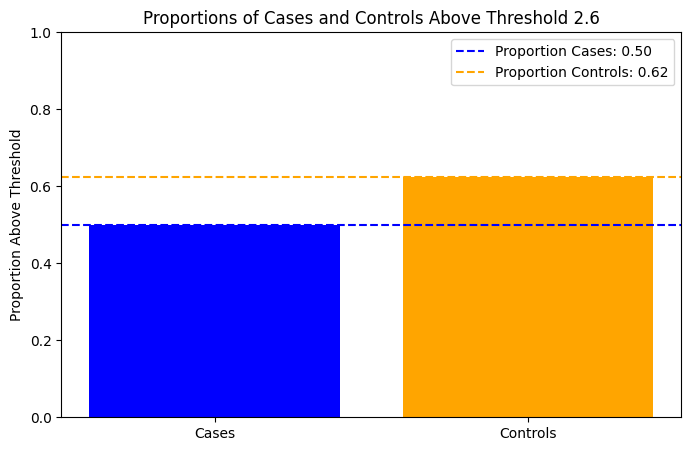


Select the type of analysis you want to perform:
1: Compare means (Selected Column)
2: Compare proportions (Above Threshold)
3: Odds ratio analysis (Above Threshold)


Enter the number corresponding to your choice (1/2/3):  3


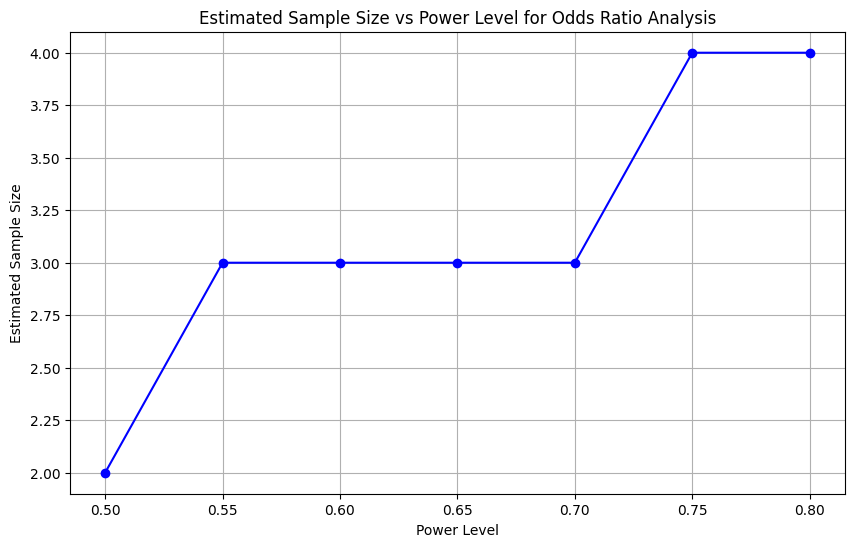

In [5]:
# Deal with equal and unequal number of Samples

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load the microbiome diversity data from CSV
data = pd.read_csv('../data/Richness_total_Equal.csv')  # Equal number of samples
#data = pd.read_csv('Richness_total.csv')  # Unequal number of samples

# Display all column names for user to select
print("Available columns in the dataset:")
for col in data.columns:
    print(col)

# Ask user to enter the column to use for power calculation
column_choice = input("Enter the column name you want to use for power calculation: ")

# Check if the column exists in the DataFrame
if column_choice not in data.columns:
    raise ValueError(f"Column '{column_choice}' does not exist in the dataset.")

# Split data into Cases and Controls
case_data = data[data['Group'] == 'Cases'][column_choice]
control_data = data[data['Group'] == 'Controls'][column_choice]

# Calculate means in both groups
P_case = np.mean(case_data)
P_control = np.mean(control_data)

print(f"\nMean in Cases: {P_case:.2f}")
print(f"Mean in Controls: {P_control:.2f}")

####################################### Just to check the proportions based on Threshold ###################
# Ask for threshold value for calculating proportions
shannon_threshold = float(input("Enter the threshold value for Shannon diversity: "))

# Split data into Cases and Controls
case_data = data[data['Group'] == 'Cases'][column_choice]
control_data = data[data['Group'] == 'Controls'][column_choice]

# Function to plot the proportions of cases and controls above the threshold
def plot_proportions(case_data, control_data, threshold):
    # Calculate proportions
    P1 = np.mean(case_data > threshold)  # Proportion in 'Cases'
    P2 = np.mean(control_data > threshold)  # Proportion in 'Controls'

    # Plot
    categories = ['Cases', 'Controls']
    proportions = [P1, P2]

    plt.figure(figsize=(8, 5))
    plt.bar(categories, proportions, color=['blue', 'orange'])
    plt.ylabel('Proportion Above Threshold')
    plt.title(f'Proportions of Cases and Controls Above Threshold {threshold}')
    plt.ylim(0, 1)
    plt.axhline(y=P1, color='blue', linestyle='--', label=f'Proportion Cases: {P1:.2f}')
    plt.axhline(y=P2, color='orange', linestyle='--', label=f'Proportion Controls: {P2:.2f}')
    plt.legend()
    plt.show()

# Plot the proportions
plot_proportions(case_data, control_data, shannon_threshold)
######################################################

# Function to calculate effect size
def calculate_effect_size(case_data, control_data):
    mean_diff = np.mean(case_data) - np.mean(control_data)
    pooled_std_dev = np.sqrt((np.var(case_data) + np.var(control_data)) / 2)
    return mean_diff / pooled_std_dev if pooled_std_dev != 0 else np.nan

# Function to calculate sample size for equal groups
def sample_size_equal_groups(effect_size, std_dev, alpha=0.05, power=0.8):
    if effect_size == 0 or np.isnan(effect_size):
        return np.nan  # Avoid division by zero if effect size is invalid
    Z_alpha = norm.ppf(1 - alpha / 2)
    Z_beta = norm.ppf(power)
    numerator = 2 * (Z_alpha + Z_beta) ** 2 * std_dev ** 2
    denominator = effect_size ** 2
    return int(np.ceil(numerator / denominator)) if denominator > 0 else np.nan

# Function to calculate sample size based on Equation B (unequal group sizes)
def sample_size_unequal_groups(effect_size, std_dev, ratio, alpha=0.05, power=0.8):
    if effect_size == 0 or np.isnan(effect_size):
        return np.nan  # Avoid division by zero if effect size is invalid 
    Z_alpha = norm.ppf(1 - alpha / 2)  # Two-sided test
    Z_beta = norm.ppf(power)
    # Check if Z_beta is too large, which might cause overflow
    if np.isnan(Z_beta) or Z_beta == np.inf:
        print("Z_beta is too large or resulted in NaN, skipping this power level.")
        return np.nan
    numerator = (ratio + 1) * (Z_alpha + Z_beta) ** 2 * std_dev ** 2
    denominator = ratio * effect_size ** 2
    # Check if denominator is valid
    if denominator == 0 or np.isnan(denominator):
        print("Denominator is invalid (division by zero or NaN). Check the input values.")
        return np.nan  # Return NaN if denominator is invalid
    
    n2 = int(np.ceil(numerator / denominator))  # Sample size of the smaller group
    n1 = int(ratio * n2)  # Sample size of the larger group
    return n1, n2

# Function to calculate sample size for equal proportions
def sample_size_equal_proportions(P1, P2, alpha=0.05, power=0.8):
    Z_alpha = norm.ppf(1 - alpha / 2)
    Z_beta = norm.ppf(power)
    numerator = 2 * (Z_alpha + Z_beta) ** 2 * (P1 * (1 - P1) + P2 * (1 - P2))
    denominator = (P1 - P2) ** 2
    return int(np.ceil(numerator / denominator)) if denominator > 0 else np.nan

# Function to calculate sample size for unequal group sizes (Equation D)
def sample_size_unequal_proportions(P1, P2, ratio, alpha=0.05, power=0.8):
    Z_alpha = norm.ppf(1 - alpha / 2)  # Two-sided test
    Z_beta = norm.ppf(power)
    numerator = (Z_alpha + Z_beta) ** 2 * (P1 * (1 - P1) + P2 * (1 - P2))
    denominator = (P1 - P2) ** 2
    
    if denominator == 0 or np.isnan(denominator):
        return np.nan  # Avoid division by zero
    
    n2 = int(np.ceil(numerator / denominator))  # Sample size of smaller group
    n1 = int(np.ceil(ratio * n2))  # Sample size of larger group
    return n1, n2

# Function to calculate odds ratio
def calculate_odds_ratio(P1, P2):
    odds1 = P1 / (1 - P1) if P1 < 1 else np.inf
    odds2 = P2 / (1 - P2) if P2 < 1 else np.inf
    return odds1 / odds2 if odds2 > 0 else np.nan
    odds_ratio = odds1 / odds2
    return odds_ratio
    
# Function to calculate sample size for odds ratio
def sample_size_odds_ratio(P1, P2, alpha=0.05, power=0.8):
    OR = calculate_odds_ratio(P1, P2)
    Z_alpha = norm.ppf(1 - alpha / 2)
    Z_beta = norm.ppf(power)
    numerator = (Z_alpha + Z_beta) ** 2
    denominator = np.log(OR) ** 2 * (1 / (P1 * (1 - P1)) + 1 / (P2 * (1 - P2)))
    return int(np.ceil(numerator / denominator)) if denominator > 0 else np.nan

# Function to calculate sample size for unequal group sizes
def sample_size_unequal_odds_ratio(P1, P2, ratio, alpha=0.05, power=0.8):
    OR = calculate_odds_ratio(P1, P2)
    if OR == np.inf:
        print("One of the proportions is zero; odds ratio is infinite.")
        return np.nan  # Cannot calculate sample size
    Z_alpha = norm.ppf(1 - alpha / 2)  # Two-sided test
    Z_beta = norm.ppf(power)
    # Numerator based on Equation F (for odds ratio)
    numerator = (Z_alpha + Z_beta) ** 2
    # Denominator (effect size term involving proportions)
    denominator = np.log(OR) ** 2 * (1 / (P1 * (1 - P1)) + 1 / (P2 * (1 - P2)))
    # Sample size for smaller group
    if denominator <= 0:
        print("Denominator is zero or negative; invalid sample size.")
        return np.nan
    n2 = numerator / denominator
    n2 = int(np.ceil(n2))
    # Larger group sample size
    n1 = int(np.ceil(ratio * n2))
    return n1, n2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Your other code above here...

# Function to handle both equal and unequal group sizes in plots
def plot_sample_size(power_levels, sample_sizes_cases, sample_sizes_controls, analysis_type, equal_groups):
    plt.figure(figsize=(10, 6))
    
    if equal_groups:
        # Plot a single line for equal group sizes
        plt.plot(power_levels, sample_sizes_cases, marker='o', linestyle='-', color='blue')
    else:
        # Plot separate lines for cases and controls when sample sizes are unequal
        plt.plot(power_levels, sample_sizes_cases, marker='o', linestyle='-', color='blue', label='Cases Sample Size')
        plt.plot(power_levels, sample_sizes_controls, marker='o', linestyle='-', color='red', label='Controls Sample Size')
        plt.legend()

    plt.title(f'Estimated Sample Size vs Power Level for {analysis_type}')
    plt.xlabel('Power Level')
    plt.ylabel('Estimated Sample Size')
    plt.xticks(power_levels)
    plt.grid()
    plt.show()

# User input for type of analysis
print("\nSelect the type of analysis you want to perform:")
print("1: Compare means (Selected Column)")
print("2: Compare proportions (Above Threshold)")
print("3: Odds ratio analysis (Above Threshold)")
analysis_type = int(input("Enter the number corresponding to your choice (1/2/3): "))

# Define power levels
power_levels = np.arange(0.50, 0.85, 0.05)  # From 0.50 to 0.80
sample_sizes_cases = []
sample_sizes_controls = []
equal_groups = len(case_data) == len(control_data)

if analysis_type == 1:  # Compare Means
    effect_size = calculate_effect_size(case_data, control_data)
    std_dev = np.sqrt((np.var(case_data) + np.var(control_data)) / 2)

    for power in power_levels:
        if equal_groups:
            sample_size = sample_size_equal_groups(effect_size, std_dev, power=power)
            sample_sizes_cases.append(sample_size)
        else:
            ratio = len(case_data) / len(control_data)
            n1, n2 = sample_size_unequal_groups(effect_size, std_dev, ratio, power=power)
            sample_sizes_cases.append(n1)
            sample_sizes_controls.append(n2)

    plot_sample_size(power_levels, sample_sizes_cases, sample_sizes_controls, "Means Comparison", equal_groups)

elif analysis_type == 2:  # Compare Proportions
    P1 = np.mean(case_data > shannon_threshold)
    P2 = np.mean(control_data > shannon_threshold)

    for power in power_levels:
        if equal_groups:
            sample_size = sample_size_equal_proportions(P1, P2, power=power)
            sample_sizes_cases.append(sample_size)
        else:
            ratio = len(case_data) / len(control_data)
            n1, n2 = sample_size_unequal_proportions(P1, P2, ratio, power=power)
            sample_sizes_cases.append(n1)
            sample_sizes_controls.append(n2)

    plot_sample_size(power_levels, sample_sizes_cases, sample_sizes_controls, "Proportions Comparison", equal_groups)

elif analysis_type == 3:  # Odds Ratio Analysis
    P1 = np.mean(case_data > shannon_threshold)
    P2 = np.mean(control_data > shannon_threshold)

    for power in power_levels:
        if equal_groups:
            sample_size = sample_size_odds_ratio(P1, P2, power=power)
            sample_sizes_cases.append(sample_size)
        else:
            ratio = len(case_data) / len(control_data)
            n1, n2 = sample_size_unequal_odds_ratio(P1, P2, ratio, power=power)
            sample_sizes_cases.append(n1)
            sample_sizes_controls.append(n2)

    plot_sample_size(power_levels, sample_sizes_cases, sample_sizes_controls, "Odds Ratio Analysis", equal_groups)

else:
    print("Invalid selection. Please run the script again.")